# Use the pure pytorch linear modules etc.,. - high level primitives and build neural network

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import numpy as np
import torch

# Utility function for 3D plot
We will be using this 3D plot in order to plot the real values of y with respect to the predicted values of y. This will help us in understading how those two values are related and how they change with or without activation function.

In [23]:
def plot_3d(comp, graph_title, X, y, y_pred=None):
    X_tnse = TSNE(n_components=comp, random_state=123).fit_transform(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
    ax.set_title(graph_title)
    if y_pred is not None:
        ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
    plt.legend()
    plt.show()

# Generating Sample data 3 inputs & 2 output

In [24]:
n = 200

# We need to take 3 inputs
inputs_dimensions = 3

# We need to have 2 outputs
output_dimensions = 2

# Setup some random seed instead of np.random.seed(2232) use Torch
torch.manual_seed(2232)

# Generating X with 3 dimentions
X = torch.rand((n, inputs_dimensions)).uniform_(-1,1)
print('Sample Value for X:' + str(X[:3]))

# Generating the value of the y_true
weights_true = np.array([[4., 3., -2.],[-1., -1., 3.]])
bias_true = np.array([[1],[1]])

y_true = (9. * X ** 2.) @ weights_true.T + X @ weights_true.T + bias_true.T

print('Sample Value for y:'+ str(y_true[:3]))


Sample Value for X:tensor([[ 0.6869, -0.6098,  0.8382],
        [ 0.2776, -0.7326,  0.4000],
        [ 0.0560,  0.3198, -0.9075]])
Sample Value for y:tensor([[14.6238, 14.8144],
        [13.4994,  1.4501],
        [-7.9519, 19.1902]], dtype=torch.float64)


# Plotting the data in a 3-Dimentional Plane

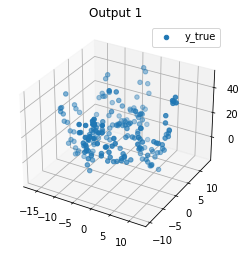

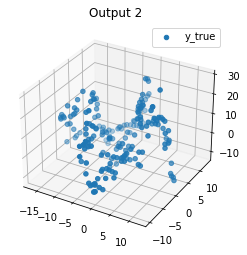

In [25]:
plot_3d(2, 'Output 1', X, y_true[:,0])
plot_3d(2, 'Output 2', X, y_true[:,1])

# Hyperparameters - Various Parameters that we will be using

In [26]:
# Number of Iterations
epochs = 200

# Learning rate of the algorithm
learning_rate = 0.01

# Inputs and outputs size. i.e 2 and 3 relatively
inputs = X.shape[1]
outputs = y_true.shape[1]

print(inputs)
print(outputs)

3
2


In [27]:
# Inspired from https://towardsdatascience.com/how-to-code-a-simple-neural-network-in-pytorch-for-absolute-beginners-8f5209c50fdd
# Inheriting from nn. Module provides functionality to your component. 
# For example, it makes it keep track of its trainable parameters, 
# you can swap it between CPU and GPU with the .to(device) method, 
# where device can be a CPU device torch. device("cpu") or CUDA device torch.
# NOTE: Regression Tasks do not have an activation function so lets avoid it

class NNModel(torch.nn.Module):
    def __init__(self, inputs=3, outputs=2, hidden=[2], activation=None):
        super(NNModel, self).__init__()

        self.num_inputs = inputs
        self.num_hidden = hidden
        self.num_outputs = outputs

        layers_nodes = [self.num_inputs] + self.num_hidden + [self.num_outputs]
    
        layers = []
        for i in range(len(layers_nodes[:-1])):
            if i == len(layers_nodes[:-1]) - 1:
                layers.append(torch.nn.Linear(layers_nodes[i], layers_nodes[i + 1]))
            else:
                layers.append(torch.nn.Linear(layers_nodes[i], layers_nodes[i + 1]))
                if activation == 'relu':
                    layers.append(torch.nn.ReLU())

        self.layers = torch.nn.ModuleList(layers)

    # Fit the model by taking in the learning rate and epochs and then iterating over the data
    def fit(self, X, y_true, learningRate, epochs):
        loss_fn  = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(self.parameters(), lr=learningRate)
        for epoch in range(epochs):
            optimizer.zero_grad()
            
            y_pred = self.forward_pass(X)
            error = loss_fn(y_pred.float(), y_true.float())
            print(error)
            error.backward()
            optimizer.step()

    # Forward pass
    def forward_pass(self, x):
        current_output = X
        for layer in self.layers:
            current_output = layer(current_output)
        return current_output

# Training Performed using RELU as Activation

## Let's see the number of layers

In [28]:
neuralModel = NNModel(inputs=inputs, outputs=outputs, hidden=[3, 2],  activation='relu')
print('Neural Network Architecture:')
print(neuralModel.layers)

Neural Network Architecture:
ModuleList(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=2, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2, out_features=2, bias=True)
)


In [29]:
for identifier, params in neuralModel.named_parameters():
  print(f"Layer: {identifier} | Size: {params.size()} | Values : {params[:2]} \n")

neuralModel.fit(X, y_true, learning_rate, epochs)

y_pred = neuralModel.forward_pass(X).detach().numpy()
err = mean_squared_error(y_true, y_pred)
print('Final Error: {}'.format(err))

Layer: layers.0.weight | Size: torch.Size([3, 3]) | Values : tensor([[-0.3693, -0.1685,  0.2800],
        [ 0.0807,  0.5107,  0.4394]], grad_fn=<SliceBackward>) 

Layer: layers.0.bias | Size: torch.Size([3]) | Values : tensor([ 0.1906, -0.4024], grad_fn=<SliceBackward>) 

Layer: layers.2.weight | Size: torch.Size([2, 3]) | Values : tensor([[ 0.0739,  0.2167,  0.1767],
        [ 0.1218, -0.1301,  0.2659]], grad_fn=<SliceBackward>) 

Layer: layers.2.bias | Size: torch.Size([2]) | Values : tensor([ 0.0723, -0.4725], grad_fn=<SliceBackward>) 

Layer: layers.4.weight | Size: torch.Size([2, 2]) | Values : tensor([[ 0.4348, -0.4114],
        [-0.0841,  0.0022]], grad_fn=<SliceBackward>) 

Layer: layers.4.bias | Size: torch.Size([2]) | Values : tensor([0.0363, 0.3102], grad_fn=<SliceBackward>) 

tensor(265.7015, grad_fn=<MseLossBackward>)
tensor(262.7129, grad_fn=<MseLossBackward>)
tensor(259.6125, grad_fn=<MseLossBackward>)
tensor(256.3230, grad_fn=<MseLossBackward>)
tensor(252.7459, grad_fn=

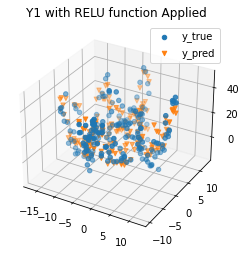

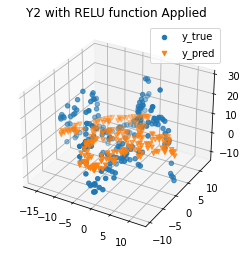

In [30]:
# Replotting the sample with y_true and y_pred
plot_3d(2, 'Y1 with RELU function Applied', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Y2 with RELU function Applied', X, y_true[:,1], y_pred[:,1])

# With No Activation function 

## Let's see the number of layers

In [34]:
neuralModel = NNModel(inputs=inputs, outputs=outputs, hidden=[3, 2],  activation='')
print('Neural Network Architecture:')
print(neuralModel.layers)

for identifier, params in neuralModel.named_parameters():
  print(f"Layer: {identifier} | Size: {params.size()} | Values : {params[:2]} \n")



Neural Network Architecture:
ModuleList(
  (0): Linear(in_features=3, out_features=3, bias=True)
  (1): Linear(in_features=3, out_features=2, bias=True)
  (2): Linear(in_features=2, out_features=2, bias=True)
)
Layer: layers.0.weight | Size: torch.Size([3, 3]) | Values : tensor([[-0.5130, -0.1575, -0.3815],
        [-0.1166,  0.4373, -0.4183]], grad_fn=<SliceBackward>) 

Layer: layers.0.bias | Size: torch.Size([3]) | Values : tensor([0.2243, 0.1883], grad_fn=<SliceBackward>) 

Layer: layers.1.weight | Size: torch.Size([2, 3]) | Values : tensor([[-0.2023,  0.3108,  0.1878],
        [-0.2766,  0.3405, -0.0674]], grad_fn=<SliceBackward>) 

Layer: layers.1.bias | Size: torch.Size([2]) | Values : tensor([0.2758, 0.5515], grad_fn=<SliceBackward>) 

Layer: layers.2.weight | Size: torch.Size([2, 2]) | Values : tensor([[-0.4341,  0.4736],
        [ 0.3552,  0.1158]], grad_fn=<SliceBackward>) 

Layer: layers.2.bias | Size: torch.Size([2]) | Values : tensor([-0.1678, -0.0632], grad_fn=<SliceBackw

In [35]:
neuralModel.fit(X, y_true, learning_rate, epochs)

y_pred = neuralModel.forward_pass(X).detach().numpy()
err = mean_squared_error(y_true, y_pred)
print('Final Error: {}'.format(err))


tensor(268.8052, grad_fn=<MseLossBackward>)
tensor(264.4194, grad_fn=<MseLossBackward>)
tensor(259.7109, grad_fn=<MseLossBackward>)
tensor(254.4803, grad_fn=<MseLossBackward>)
tensor(248.5073, grad_fn=<MseLossBackward>)
tensor(241.5402, grad_fn=<MseLossBackward>)
tensor(233.2894, grad_fn=<MseLossBackward>)
tensor(223.4393, grad_fn=<MseLossBackward>)
tensor(211.6980, grad_fn=<MseLossBackward>)
tensor(197.9542, grad_fn=<MseLossBackward>)
tensor(182.6450, grad_fn=<MseLossBackward>)
tensor(167.3579, grad_fn=<MseLossBackward>)
tensor(155.0118, grad_fn=<MseLossBackward>)
tensor(148.0423, grad_fn=<MseLossBackward>)
tensor(145.5939, grad_fn=<MseLossBackward>)
tensor(144.9244, grad_fn=<MseLossBackward>)
tensor(144.6115, grad_fn=<MseLossBackward>)
tensor(144.3703, grad_fn=<MseLossBackward>)
tensor(144.1662, grad_fn=<MseLossBackward>)
tensor(143.9921, grad_fn=<MseLossBackward>)
tensor(143.8434, grad_fn=<MseLossBackward>)
tensor(143.7165, grad_fn=<MseLossBackward>)
tensor(143.6084, grad_fn=<MseLos

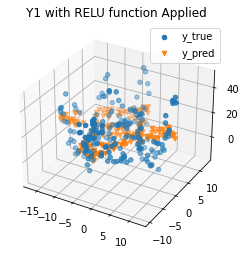

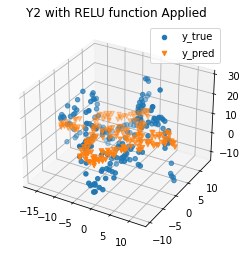

In [36]:
# Replotting the sample with y_true and y_pred
plot_3d(2, 'Y1 with RELU function Applied', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Y2 with RELU function Applied', X, y_true[:,1], y_pred[:,1])